In [1]:
import os 

import datasets
import json
import numpy as np
import pandas as pd
import torch
from collections import defaultdict

from sklearn.metrics import roc_auc_score
from lm_polygraph.utils.manager import UEManager, _delete_nans, _recombine_data
from lm_polygraph.ue_metrics.ue_metric import get_random_scores
from lm_polygraph.ue_metrics.risk_cov_curve import RiskCoverageCurveAUC
from lm_polygraph.ue_metrics.pred_rej_area import PredictionRejectionArea
from transformers import AutoTokenizer

prr = PredictionRejectionArea()

/home/jovyan/.mlspace/envs/tmd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt

paths = {
    "GPT-4o-mini": [
        "../workdir/output_proxy/mmlu_empirical_baselines/qa/gpt-4o-mini/['cais/mmlu', 'all']/2024-12-11/15-31-48/ue_manager_seed1",
        "../workdir/output_proxy/coqa_empirical_baselines/qa/gpt-4o-mini/coqa/2024-12-11/14-05-31/ue_manager_seed1"
    ],
}

In [15]:
import torch

def preproc_method_name(x):
    label = x
    if "HUQ" in x:
        label = "HUQ-SATMD"
    elif "Hybrid" in x:
        label = "SATMD+MSP"
    elif "LinReg" in x:
        label = "SATMD"
    elif "Fact" in x:
        label = "Factoscope"
    elif "SAPLMA" in x:
        label = "SAPLMA"
    elif "EigenScore" in x:
        label = "EigenScore"
        
    if "relative" in x.lower():
        label = label.replace("TMD", "TRMD")

    if "electra_base" in x:
        label += "_electra_base"
    if "roberta_base" in x:
        label += "_roberta_base"
    if "roberta_large" in x:
        label += "_roberta_large"
    if "llama3b" in x:
        label += "_llama_3b"
    if "llama1b" in x:
        label += "_llama_1b"
    if "sim_pca" in x:
        label += " (new pca)"
    return label

def get_table(path, metric_names=["Rouge_rougeL", 'AlignScore'], base_metric="Accuracy", dataset="CoQA", ue_metric="prr_normalized", level="sequence"):
    man = torch.load(path, weights_only=False)
    df = {}
    methods = np.unique([x[1] for x in man['metrics'].keys() if "2side" not in x[1]])
    for method in methods:
        for metric in metric_names:
            try:
                key = (level, method, metric, ue_metric)
                scores = df.get(method, [])
                scores.append(man['metrics'][key])
                df[method] = scores
            except:
                print("error: ", key)
                pass

    df0 = pd.DataFrame(df, index=pd.MultiIndex.from_tuples([(dataset, m) for m in metric_names])).T

    for metric in metric_names:
        print(f"{metric}:", np.mean(man['gen_metrics'][('sequence', metric)]))

    # baselines = ['MaximumSequenceProbability', 'Perplexity', 'MeanTokenEntropy', 'MonteCarloNormalizedSequenceEntropy', 'MonteCarloSequenceEntropy', 'NumSemSets', 
    #              'DegMat_NLI_score_entail', 'Eccentricity_NLI_score_entail', 'EigValLaplacian_NLI_score_entail', 'LexicalSimilarity_rougeL', 'SAR', 'SemanticEntropy', 'SentenceSAR']
    baselines = ['NumSemSets', 'DegMat_NLI_score_entail', 'DegMat_Jaccard_score', 'Eccentricity_NLI_score_entail', 'Eccentricity_Jaccard_score', 
                 'EigValLaplacian_NLI_score_entail', 'EigValLaplacian_Jaccard_score', 'LexicalSimilarity_rougeL']
    cols = df0.index.values
    n_layers = len([x for x in cols if "EigenScore" in x])
    mid_layer = int(n_layers // 2)
    # density_baselines = [f"FactoscopeAll_dist_new_{base_metric}", f"EigenScore sample_embeddings_last_token_{mid_layer}", f"SAPLMA_decoder_{mid_layer} (cv, {base_metric})"]
    trans_bb_baselines = [f"TransformerUQ_{model} ({base_metric})" for model in ['roberta_base', 'roberta_large']]
    proposed_methods = [col for col in cols if "LinReg" in col]
    
    final_methods = baselines + trans_bb_baselines + proposed_methods# + density_baselines
    df0 = df0.loc[final_methods]
    method = [preproc_method_name(x) for x in df0.index if x in final_methods]
    df0.loc[:, (dataset, 'Method')] = method
    return df0.reset_index(drop=True)

In [25]:
base_path = "../workdir/output_proxy_1"

models = ["gpt-4o-mini"]
# datasets = ["xsum", "samsum", "cnn", "pubmed", "medquad", "truthful_qa", "coqa", "sciq", "trivia_qa", "gsm8k", "mmlu"]
datasets = ["xsum", "samsum", "cnn", "truthful_qa", "coqa"]#, "sciq", "trivia_qa", "mmlu"]

dfs = {}
for model in models:
    dfs[model] = []
    for ds in datasets:
        for root, dirs, files in os.walk(base_path):
            for file in files:
                if file.endswith("seed1") and (model in root.lower()) and (ds in root.lower()):
                    print(root, file)
                    full_path = f"{root}/{file}"
                    # metric_names = ["Rouge_rougeL", 'AlignScoreMean'] if ds not in ["coqa", "sciq", "trivia_qa", "gsm8k", "mmlu"] else ["Accuracy"]
                    metric_names = ["Rouge_rougeL"] if ds not in ["coqa", "sciq", "trivia_qa", "gsm8k", "mmlu"] else ["Accuracy"]
                    metric_names = ['AlignScoreMean'] if ds in ["truthful_qa"] else metric_names
                    metric_names = ['AlignScore'] if ds in ["coqa", "sciq", "trivia_qa"] else metric_names
                    df = get_table(full_path, dataset=ds, metric_names=metric_names, base_metric="AlignScore" if ds not in ["coqa", "sciq", "trivia_qa", "gsm8k", "mmlu"] else "Accuracy")
                    base_idx = [0,1] + list(range(6, 16))
                    # dfs[model].append(df.iloc[base_idx + [18, 16]])
                    # dfs[model].append(df.iloc[base_idx + [19, 18]])
                    dfs[model].append(df)#.iloc[base_idx + [21, 20, 19, 18, 17, 16]])
                    # dfs[model].append(df.iloc[base_idx + [19, 18, 17, 16]])
                    # dfs[model].append(df.iloc[base_idx + [16, 18]])
                    # dfs[model].append(df.iloc[base_idx + [20, 16, 18]])
                    break

../workdir/output_proxy_1/xsum_empirical_baselines/ats/gpt-4o-mini/xsum/2024-12-15/07-02-28 ue_manager_seed1
error:  ('sequence', 'RelativeTokenMahalanobisDistance_proxy_electra_base_decoder_3 (mean, AlignScore, 0.3)', 'Rouge_rougeL', 'prr_normalized')
error:  ('sequence', 'RelativeTokenMahalanobisDistance_proxy_roberta_base_decoder_5 (mean, AlignScore, 0.3)', 'Rouge_rougeL', 'prr_normalized')
error:  ('sequence', 'TokenMahalanobisDistance_proxy_electra_base_decoder_3 (mean, AlignScore, 0.3)', 'Rouge_rougeL', 'prr_normalized')
Rouge_rougeL: 0.17255392229638158
../workdir/output_proxy_1/samsum_empirical_baselines/ats/gpt-4o-mini/samsum/2024-12-15/16-59-55 ue_manager_seed1
Rouge_rougeL: 0.2844087756495353
../workdir/output_proxy_1/cnn_empirical_baselines/ats/gpt-4o-mini/['cnn_dailymail', '3.0.0']/2024-12-16/00-26-36 ue_manager_seed1
error:  ('sequence', 'RelativeTokenMahalanobisDistance_proxy_roberta_base_decoder_5 (mean, AlignScore, 0.3)', 'Rouge_rougeL', 'prr_normalized')
Rouge_rougeL:

In [27]:
from scipy.stats import rankdata

base_idx = list(range(7))

model = 'gpt-4o-mini'
final_dfs = []
for i, df in enumerate(dfs[model]):
    if i==0:
        final_dfs.append(df[df.columns[[1,0]]])#.loc[base_idx + [26, 16, 20, 10]].reset_index(drop=True))
    elif i > (len(dfs[model]) - 3):
        final_dfs.append(df[df.columns[[0]]])#.loc[base_idx + [26, 16, 20, 10]].reset_index(drop=True))
    else:
        final_dfs.append(df[df.columns[[0]]])#.loc[base_idx + [26, 16, 20, 10]].reset_index(drop=True))

df_g = pd.concat(final_dfs, axis=1)
df_g.loc[:, ('', "Mean Rank")] = df_g[df_g.columns[1:]].apply(lambda x: rankdata(-x)).mean(axis=1).round(2)
df_g.loc[:, ('', "Mean PRR")] = df_g[df_g.columns[1:-1]].mean(axis=1)
df_g.loc[:, ('', "Top1 Rate")] = df_g[df_g.columns[1:-2]].apply(lambda x: rankdata(-x) == 1).sum(axis=1).round(2)

df_g.style.background_gradient(axis=0)

In [31]:
from scipy.stats import rankdata

base_idx = list(range(10))

model = 'gpt-4o-mini'
final_dfs = []
for i, df in enumerate(dfs[model]):
    if i==0:
        final_dfs.append(df[df.columns[[1,0]]].loc[base_idx + [28, 18, 22, 12]].reset_index(drop=True))
    elif i > (len(dfs[model]) - 3):
        final_dfs.append(df[df.columns[[0]]].loc[base_idx + [28, 18, 22, 12]].reset_index(drop=True))
    else:
        final_dfs.append(df[df.columns[[0]]].loc[base_idx + [28, 18, 22, 12]].reset_index(drop=True))

df_g = pd.concat(final_dfs, axis=1)
df_g.loc[:, ('', "Mean Rank")] = df_g[df_g.columns[1:]].apply(lambda x: rankdata(-x)).mean(axis=1).round(2)
df_g.loc[:, ('', "Mean PRR")] = df_g[df_g.columns[1:-1]].mean(axis=1)
df_g.loc[:, ('', "Top1 Rate")] = df_g[df_g.columns[1:-2]].apply(lambda x: rankdata(-x) == 1).sum(axis=1).round(2)

df_g.style.background_gradient(axis=0)

In [91]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns

col = df_l.columns[0]
methods = df_l[col].values
win_rate = np.zeros((len(methods), len(methods)))

for i, m1 in enumerate(methods):
    for j, m2 in enumerate(methods):
        win_rate[i, j] = np.concatenate([(df_l.iloc[i].values[1:-3] > df_l.iloc[j].values[1:-3]),
                                         #(df_q.iloc[i].values[1:-3] > df_q.iloc[j].values[1:-3]),
                                         (df_g.iloc[i].values[1:-3] > df_g.iloc[j].values[1:-3]),
                                        ]).mean()

In [92]:
# methods_name = ["MSP", "Perplexity", 'DegMat NLI entail.', 'Ecc. NLI entail.', 'EVL NLI entail.', 'LexSim Rouge-L',
#                 'Semantic Entropy', 'SentenceSAR', 'SAR', 'Factoscope', 'EigenScore', "SAPLMA", "LinRegTMD+MSP"]

methods_name = ["MSP", "Perplexity", 'DegMat NLI entail.', 'Ecc. NLI entail.', 'EVL NLI entail.', 'LexSim Rouge-L',
                'Semantic Entropy', 'SentenceSAR', 'SAR', 'Factoscope', 'EigenScore', "SAPLMA", "LinRegTMD", "LinRegTMD Rel", "LinRegTMD+MSP", "LinRegTMD+MSP Rel.", "HUQ", "HUQ Rel"]

methods_name = ["MSP", "Perplexity", 'DegMat NLI entail.', 'Ecc. NLI entail.', 'EVL NLI entail.', 'LexSim Rouge-L',
                'Semantic Entropy', 'SentenceSAR', 'SAR', 'Factoscope', 'EigenScore', "SAPLMA", "HUQ Rel", "LinRegTMD+MSP Rel."]

win_rate_labels = []

for x in win_rate:
    win_rate_labels.append([])
    for a in x:
        if a!=1:
            win_rate_labels[-1].append(f"{a:.2f}"[1:])
        else:
            win_rate_labels[-1].append("1.0")

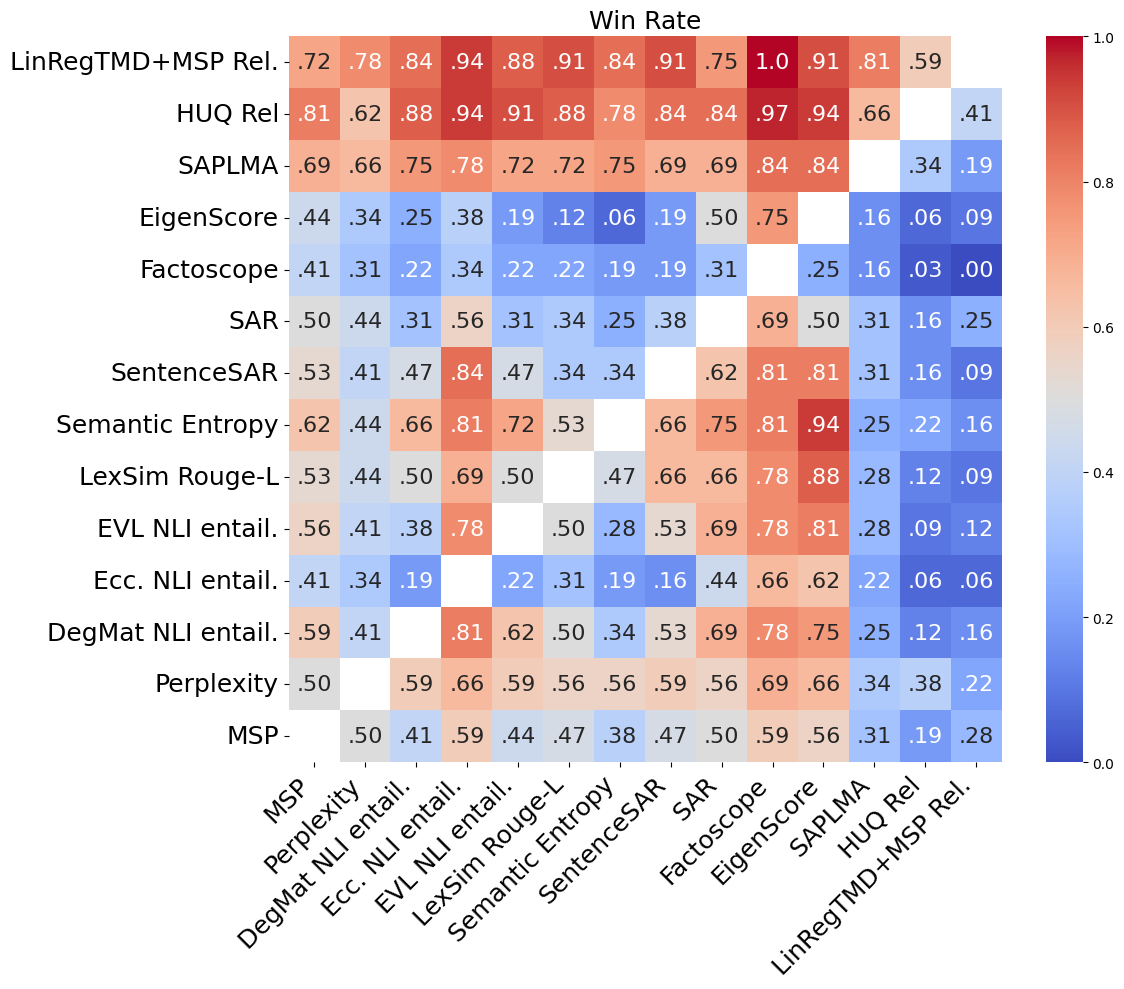

In [93]:
def plot_heatmap(pathOut, fileName, data, title, labels, mask, precis=3, show=False):
    n = data.shape[0]
    data = data.reshape(n, n)

    fig, ax = plt.subplots(figsize=(12, 10))
    # p = sns.heatmap(data=data, annot=True, fmt=f'.{precis}f', ax=ax, mask=mask,
    #                 cmap="coolwarm", xticklabels=labels, yticklabels=labels)
    p = sns.heatmap(data=data, annot=win_rate_labels, fmt='', ax=ax, mask=mask,
                    cmap="coolwarm", xticklabels=labels, yticklabels=labels, annot_kws={"size": 16})
    #ax.xaxis.tick_top()
    ax.invert_yaxis()  # invert the axis if desired
    ax.set_title(f'{title}', fontsize=18)
    plt.xticks(rotation=45, ha='right', fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    fig.savefig(f'{pathOut}/{fileName}.pdf', format='pdf') 
    if (show == False):
        plt.close(fig)        
    elif (show == True):        
        plt.show()

mask = np.eye(len(win_rate), dtype=bool)
plot_heatmap('../workdir/', 'win_rate', win_rate, 'Win Rate', methods_name, mask, 3, True)

In [363]:
import matplotlib 
from matplotlib import colors
import matplotlib.pyplot as plt 

cmap = matplotlib.cm.get_cmap('coolwarm')#'Greens')
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = 0.5
my_cmap = colors.ListedColormap(my_cmap)

def b_g(s, cmap, low=0, high=0):
    values = s.apply(lambda x: float(x.split("±")[0]) if len(x.split("±"))>1 else x)
    if isinstance(values.max(), str):
        return ['' for c in values]
    rng = values.max() - values.min()
    norm = colors.Normalize(values.min() - (rng * low), values.max() + (rng * high))
    normed = norm(values.values)
    back_colors = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    text_colors = ["white" if x>0.3 else "black" for x in normed]
    return [f'color: {text_color}; background-color: {color}' for text_color, color in zip(text_colors, back_colors)]

/tmp/ipykernel_2230/1380247612.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('coolwarm')#'Greens')


In [364]:
def rgba2rgb(rgba, background=(1,1,1)):
    ch = rgba.shape[0]
    if ch == 3:
        return rgba

    assert ch == 4, 'RGBA image has 4 channels.'

    r, g, b, a = rgba[0], rgba[1], rgba[2], rgba[3]
    a = np.asarray(a, dtype='float32')
    R, G, B = background

    r_new = r * a + (1.0 - a) * R
    g_new = g * a + (1.0 - a) * G
    b_new = b * a + (1.0 - a) * B

    return [r_new, g_new, b_new]


def to_color(text, vals, remove_zeros, bold=False, underline=False):
    vals = rgba2rgb(np.array(vals))
    if remove_zeros:
        number = f'{text:.3f}'
        if number[0] == "-":
            number = number[:1] + number[2:]
        else:
            number = number[1:]
        if bold:
            return '\\cellcolor[rgb]{'+f'{vals[0]},'+f'{vals[1]},'+f'{vals[2]}'+'} '+ "\\textbf{"+number+"}"
        if underline:
            return '\\cellcolor[rgb]{'+f'{vals[0]},'+f'{vals[1]},'+f'{vals[2]}'+'} '+ "\\underline{"+number+"}"
        return '\\cellcolor[rgb]{'+f'{vals[0]},'+f'{vals[1]},'+f'{vals[2]}'+'} '+ number
    if bold:
        return '\\cellcolor[rgb]{'+f'{vals[0]},'+f'{vals[1]},'+f'{vals[2]}'+'} '+ "\\textbf{"+f'{text:.2f}'+"}"
    if underline:
        return '\\cellcolor[rgb]{'+f'{vals[0]},'+f'{vals[1]},'+f'{vals[2]}'+'} '+ "\\underline{"+f'{text:.2f}'+"}"
    return '\\cellcolor[rgb]{'+f'{vals[0]},'+f'{vals[1]},'+f'{vals[2]}'+'} '+f'{text:.2f}'

def bold_best(df, columns, remove_zeros):
    for col in columns:
        values_init_raw = [float(x) if x!='-' else np.nan for x in df[col]]
        values_init = np.array([float(x) for x in df[col] if x!='-'])
        if values_init.min() != values_init.max():
            values_init_raw = np.array([(x - values_init.min()) / (values_init.max() - values_init.min()) if not np.isnan(x) else x for x in values_init_raw])
            
        def get_new_x(x):
            if isinstance(x, str):
                return x
            return '-'

        def preproc_x(x):
            # if remove_zeros:
            #     return int(x*1000)
            return x

        remove_zeros = True
        if "rank" in col[-1].lower():
            remove_zeros = False
        if "impr" in col[-1].lower():
            remove_zeros = False

        if "rank" not in col[-1].lower():
            max_val = df[col].replace('-', 0).nlargest(2)
            values = [to_color(preproc_x(raw), my_cmap(float(x)), remove_zeros, bold=(raw==max_val.iloc[0]), underline=(raw==max_val.iloc[1])) if (isinstance(x, float) and (not np.isnan(x))) else get_new_x(x) for raw, x in zip(df[col], values_init_raw)]
        else:
            max_val = df[col].replace('-', 0).nsmallest(2)
            values = [to_color(preproc_x(raw), my_cmap(1-float(x)), remove_zeros, bold=(raw==max_val.iloc[0]), underline=(raw==max_val.iloc[1])) if (isinstance(x, float) and (not np.isnan(x))) else get_new_x(x) for raw, x in zip(df[col], values_init_raw)]
        df[col] = values
    return df

def prepare_latex(df1, s=2, remove_zeros=False):
    start_tex = '\\begin{table*}[!ht] \\resizebox{\\textwidth}{!}{'
    end_tex = "}\\caption{\\label{tab:mistral_results} PRR$\\uparrow$ for Mistral 7b v0.2 model for various tasks for the considered sequence-level methods. Darker color indicates better results.}\end{table*}"
    df1 = bold_best(df1, df1.columns[s:], remove_zeros)
    latex_table = df1.to_latex(bold_rows=False, index=False).replace('±', '$\pm$')
        
    latex_table = latex_table.replace('\\textbackslash ', '\\')
    latex_table = latex_table.replace('{lllllllllllllllllllll}', '{ll||cc|cc|cc|cc|cc|cc|cc|cc|cc|c}')
    latex_table = latex_table.replace('{lrllllllllllllllllllll}', '{l||cc|cc|cc|cc|cc|cc|cc|cc|cc|c|c|c}')
    latex_table = latex_table.replace('{llllllllllllllllllllll}', '{l||cc|cc|cc|cc|cc|cc|cc|cc|cc|c|c|c}')
    latex_table = latex_table.replace('{llllllllllllllllllll}', '{l||cc|cc|cc|cc|cc|cc|cc|cc|cc|c}')
    latex_table = latex_table.replace('{lrllllllllllllllllll}', '{l||cc|cc|cc|cc|cc|cc|cc|cc|cc|c}')
    latex_table = latex_table.replace('{lllllllllllllll}', '{ll||cc|cc|cc|cc|cc|cc|c}')
    latex_table = latex_table.replace('{lllllllll}', '{l||cc|cc|cc|c|c}')
    latex_table = latex_table.replace('{llllllll}', '{l||cc|cc|cc|c}')
    

    latex_table = latex_table.replace('mean', '$\\frac{1}{K}\\sum_{k=1}^K p_k$')
    latex_table = latex_table.replace('sum(log(p_i))', '$\\sum_{k=1}^K \\log p_k$')

    latex_table = latex_table.replace('\\{', '{')
    latex_table = latex_table.replace('\\}', '}')
    str_list = latex_table.split('\n')
    str_list.pop(3)
    latex_table = '\n'.join(str_list)
    return start_tex+latex_table+end_tex

In [108]:
names_dict = {
    "MaximumSequenceProbability": "Maximum Sequence Probability",
    "Perplexity":"Perplexity",

    "MeanTokenEntropy":"Mean Token Entropy",
    "MutualInformation":"Pointwise Mutual Information",
    "MeanPointwiseMutualInformation": "Pointwise Mutual Information",
    "MeanConditionalPointwiseMutualInformation":"Conditional Pointwise Mutual Information",

    "PTrueSampling":"P(True) Sampling",
    "PTrue":"P(True)",

    "SemanticEntropy": "Semantic Entropy",
    "MonteCarloSequenceEntropy": "Monte Carlo Sequence Entropy",
    "MonteCarloNormalizedSequenceEntropy":"Monte Carlo Normalized Sequence Entropy",

    "LexicalSimilarity_rouge1":"Lexical Similarity Rouge-1",
    "LexicalSimilarity_rouge2":"Lexical Similarity Rouge-2",
    "LexicalSimilarity_rougeL":"Lexical Similarity Rouge-L",
    "LexicalSimilarity_BLEU":"Lexical Similarity BLEU",

    'EigValLaplacian_Jaccard_score':'EigValLaplacian Jaccard Score', 
    'DegMat_Jaccard_score':'DegMat Jaccard Score',
    'Eccentricity_Jaccard_score': 'Eccentricity Jaccard Score',

    'EigValLaplacian_NLI_score_contra':'EigValLaplacian NLI Score contra.', 
    'DegMat_NLI_score_contra':'DegMat NLI Score Contra.',
    'Eccentricity_NLI_score_contra': 'Eccentricity NLI Score contra.',

    'EigValLaplacian_NLI_score_entail':'EigValLaplacian NLI Score entail.', 
    'DegMat_NLI_score_entail':'DegMat NLI Score entail.',
    'Eccentricity_NLI_score_entail': 'Eccentricity NLI Score entail.',

    "MahalanobisDistanceSeq_decoder":"Mahalanobis Distance - Decoder",
    "RelativeMahalanobisDistanceSeq_decoder":"Relative Mahalanobis Distance - Decoder",
    "RDESeq_decoder":"RDE - Decoder",
    "PPLMDSeq_decoder":"HUQ-MD - Decoder",
    "PPLRMDSeq_decoder":"HUQ-RMD - Decoder",
}

In [109]:
df_g[("xsum", "Method")] = df_g[("xsum", "Method")].apply(lambda x: names_dict.get(x, x))
df_l[("xsum", "Method")] = df_l[("xsum", "Method")].apply(lambda x: names_dict.get(x, x))

KeyError: ('xsum', 'Method')

In [345]:
import copy

with pd.option_context("max_colwidth", 1000):
    res_str = prepare_latex(copy.deepcopy(df_l[df_l.columns[:-2]]).round(3),1,True).split('\n')
    res_str[2] = """\\multirow{2}{*}{\\textbf{UQ Method}} & \multicolumn{2}{c|}{\\textbf{XSUM}} & \multicolumn{2}{c|}{\\textbf{SamSum}} & \multicolumn{2}{c|}{\\textbf{CNN}}& \multicolumn{2}{c|}{\\textbf{PubMedQA}} & \multicolumn{2}{c|}{\\textbf{MedQUAD}} & \multicolumn{1}{c|}{\\textbf{TruthfulQA}}& \multicolumn{1}{c|}{\\textbf{CoQA}} & \multicolumn{1}{c|}{\\textbf{SciQ}} & \multicolumn{1}{c|}{\\textbf{TriviaQA}} & \multicolumn{1}{c|}{\\textbf{GSM8k}} & \multicolumn{1}{c|}{\\textbf{MMLU}} & \\multirow{2}{*}{\\textbf{Mean Rank}} \\\\ \\cline{2-17}
    & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{AlignScore} & \\textbf{AlignScore} & \\textbf{AlignScore}& \\textbf{AlignScore} & \\textbf{Accuracy}& \\textbf{Accuracy}& \\\\"""
    print('\n'.join(res_str))

\begin{table*}[!ht] \resizebox{\textwidth}{!}{\begin{tabular}{llllllllllllllllll}
\toprule
\multirow{2}{*}{\textbf{UQ Method}} & \multicolumn{2}{c|}{\textbf{XSUM}} & \multicolumn{2}{c|}{\textbf{SamSum}} & \multicolumn{2}{c|}{\textbf{CNN}}& \multicolumn{2}{c|}{\textbf{PubMedQA}} & \multicolumn{2}{c|}{\textbf{MedQUAD}} & \multicolumn{1}{c|}{\textbf{TruthfulQA}}& \multicolumn{1}{c|}{\textbf{CoQA}} & \multicolumn{1}{c|}{\textbf{SciQ}} & \multicolumn{1}{c|}{\textbf{TriviaQA}} & \multicolumn{1}{c|}{\textbf{GSM8k}} & \multicolumn{1}{c|}{\textbf{MMLU}} & \multirow{2}{*}{\textbf{Mean Rank}} \\ \cline{2-17}
    & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{AlignScore} & \textbf{AlignScore} & \textbf{AlignScore}& \textbf{AlignScore} & \textbf{Accuracy}& \textbf{Accuracy}& \\
\midrule
Maximum Sequence Probability & \cellcolor[rgb]{

In [346]:
import copy

with pd.option_context("max_colwidth", 1000):
    res_str = prepare_latex(copy.deepcopy(df_g[df_g.columns[:-2]]).round(3),1,True).split('\n')
    res_str[2] = """\\multirow{2}{*}{\\textbf{UQ Method}} & \multicolumn{2}{c|}{\\textbf{XSUM}} & \multicolumn{2}{c|}{\\textbf{SamSum}} & \multicolumn{2}{c|}{\\textbf{CNN}}& \multicolumn{2}{c|}{\\textbf{PubMedQA}} & \multicolumn{2}{c|}{\\textbf{MedQUAD}} & \multicolumn{1}{c|}{\\textbf{TruthfulQA}}& \multicolumn{1}{c|}{\\textbf{CoQA}} & \multicolumn{1}{c|}{\\textbf{SciQ}} & \multicolumn{1}{c|}{\\textbf{TriviaQA}} & \multicolumn{1}{c|}{\\textbf{GSM8k}} & \multicolumn{1}{c|}{\\textbf{MMLU}} & \\multirow{2}{*}{\\textbf{Mean Rank}} \\\\ \\cline{2-17}
    & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{AlignScore} & \\textbf{AlignScore} & \\textbf{AlignScore}& \\textbf{AlignScore} & \\textbf{Accuracy}& \\textbf{Accuracy}& \\\\"""
    print('\n'.join(res_str))

\begin{table*}[!ht] \resizebox{\textwidth}{!}{\begin{tabular}{llllllllllllllllll}
\toprule
\multirow{2}{*}{\textbf{UQ Method}} & \multicolumn{2}{c|}{\textbf{XSUM}} & \multicolumn{2}{c|}{\textbf{SamSum}} & \multicolumn{2}{c|}{\textbf{CNN}}& \multicolumn{2}{c|}{\textbf{PubMedQA}} & \multicolumn{2}{c|}{\textbf{MedQUAD}} & \multicolumn{1}{c|}{\textbf{TruthfulQA}}& \multicolumn{1}{c|}{\textbf{CoQA}} & \multicolumn{1}{c|}{\textbf{SciQ}} & \multicolumn{1}{c|}{\textbf{TriviaQA}} & \multicolumn{1}{c|}{\textbf{GSM8k}} & \multicolumn{1}{c|}{\textbf{MMLU}} & \multirow{2}{*}{\textbf{Mean Rank}} \\ \cline{2-17}
    & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{AlignScore} & \textbf{AlignScore} & \textbf{AlignScore}& \textbf{AlignScore} & \textbf{Accuracy}& \textbf{Accuracy}& \\
\midrule
Maximum Sequence Probability & \cellcolor[rgb]{

In [347]:
import copy

with pd.option_context("max_colwidth", 1000):
    res_str = prepare_latex(copy.deepcopy(df_l_abl[df_l_abl.columns[:-2]]).round(3),1,True).split('\n')
    res_str[2] = """\\multirow{2}{*}{\\textbf{UQ Method}} & \multicolumn{2}{c|}{\\textbf{XSUM}} & \multicolumn{2}{c|}{\\textbf{SamSum}} & \multicolumn{2}{c|}{\\textbf{CNN}}& \multicolumn{2}{c|}{\\textbf{PubMedQA}} & \multicolumn{2}{c|}{\\textbf{MedQUAD}} & \multicolumn{1}{c|}{\\textbf{TruthfulQA}}& \multicolumn{1}{c|}{\\textbf{CoQA}} & \multicolumn{1}{c|}{\\textbf{SciQ}} & \multicolumn{1}{c|}{\\textbf{TriviaQA}} & \multicolumn{1}{c|}{\\textbf{GSM8k}} & \multicolumn{1}{c|}{\\textbf{MMLU}} & \\multirow{2}{*}{\\textbf{Mean Rank}} \\\\ \\cline{2-17}
    & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{AlignScore} & \\textbf{AlignScore} & \\textbf{AlignScore}& \\textbf{AlignScore} & \\textbf{Accuracy}& \\textbf{Accuracy}& \\\\"""
    print('\n'.join(res_str))

\begin{table*}[!ht] \resizebox{\textwidth}{!}{\begin{tabular}{llllllllllllllllll}
\toprule
\multirow{2}{*}{\textbf{UQ Method}} & \multicolumn{2}{c|}{\textbf{XSUM}} & \multicolumn{2}{c|}{\textbf{SamSum}} & \multicolumn{2}{c|}{\textbf{CNN}}& \multicolumn{2}{c|}{\textbf{PubMedQA}} & \multicolumn{2}{c|}{\textbf{MedQUAD}} & \multicolumn{1}{c|}{\textbf{TruthfulQA}}& \multicolumn{1}{c|}{\textbf{CoQA}} & \multicolumn{1}{c|}{\textbf{SciQ}} & \multicolumn{1}{c|}{\textbf{TriviaQA}} & \multicolumn{1}{c|}{\textbf{GSM8k}} & \multicolumn{1}{c|}{\textbf{MMLU}} & \multirow{2}{*}{\textbf{Mean Rank}} \\ \cline{2-17}
    & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{AlignScore} & \textbf{AlignScore} & \textbf{AlignScore}& \textbf{AlignScore} & \textbf{Accuracy}& \textbf{Accuracy}& \\
\midrule
STMD & \cellcolor[rgb]{0.9836582578333333,0.828

In [348]:
import copy

with pd.option_context("max_colwidth", 1000):
    res_str = prepare_latex(copy.deepcopy(df_g_abl[df_g_abl.columns[:-2]]).round(3),1,True).split('\n')
    res_str[2] = """\\multirow{2}{*}{\\textbf{UQ Method}} & \multicolumn{2}{c|}{\\textbf{XSUM}} & \multicolumn{2}{c|}{\\textbf{SamSum}} & \multicolumn{2}{c|}{\\textbf{CNN}}& \multicolumn{2}{c|}{\\textbf{PubMedQA}} & \multicolumn{2}{c|}{\\textbf{MedQUAD}} & \multicolumn{1}{c|}{\\textbf{TruthfulQA}}& \multicolumn{1}{c|}{\\textbf{CoQA}} & \multicolumn{1}{c|}{\\textbf{SciQ}} & \multicolumn{1}{c|}{\\textbf{TriviaQA}} & \multicolumn{1}{c|}{\\textbf{GSM8k}} & \multicolumn{1}{c|}{\\textbf{MMLU}} & \\multirow{2}{*}{\\textbf{Mean Rank}} \\\\ \\cline{2-17}
    & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{AlignScore} & \\textbf{AlignScore} & \\textbf{AlignScore}& \\textbf{AlignScore} & \\textbf{Accuracy}& \\textbf{Accuracy}& \\\\"""
    print('\n'.join(res_str))

\begin{table*}[!ht] \resizebox{\textwidth}{!}{\begin{tabular}{llllllllllllllllll}
\toprule
\multirow{2}{*}{\textbf{UQ Method}} & \multicolumn{2}{c|}{\textbf{XSUM}} & \multicolumn{2}{c|}{\textbf{SamSum}} & \multicolumn{2}{c|}{\textbf{CNN}}& \multicolumn{2}{c|}{\textbf{PubMedQA}} & \multicolumn{2}{c|}{\textbf{MedQUAD}} & \multicolumn{1}{c|}{\textbf{TruthfulQA}}& \multicolumn{1}{c|}{\textbf{CoQA}} & \multicolumn{1}{c|}{\textbf{SciQ}} & \multicolumn{1}{c|}{\textbf{TriviaQA}} & \multicolumn{1}{c|}{\textbf{GSM8k}} & \multicolumn{1}{c|}{\textbf{MMLU}} & \multirow{2}{*}{\textbf{Mean Rank}} \\ \cline{2-17}
    & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{AlignScore} & \textbf{AlignScore} & \textbf{AlignScore}& \textbf{AlignScore} & \textbf{Accuracy}& \textbf{Accuracy}& \\
\midrule
STMD & \cellcolor[rgb]{0.7825907906117646,0.849

## Generalization

In [95]:
def get_table_gen(path, metric_names=["Rouge_rougeL", 'AlignScore'], base_metric="Accuracy", dataset="CoQA", ue_metric="prr_normalized", level="sequence"):
    man = torch.load(path, weights_only=False)
    df = {}
    methods = np.unique([x[1] for x in man['metrics'].keys() if "2side" not in x[1]])
    for method in methods:
        for metric in metric_names:
            key = (level, method, metric, ue_metric)
            scores = df.get(method, [])
            try:
                scores.append(man['metrics'][key])
                df[method] = scores
            except:
                pass

    df0 = pd.DataFrame(df, index=pd.MultiIndex.from_tuples([(dataset, m) for m in metric_names])).T

    for metric in metric_names:
        print(f"{metric}:", np.mean(man['gen_metrics'][('sequence', metric)]))

    baselines = ['MaximumSequenceProbability']
    cols = df0.index.values
    n_layers = len([x for x in cols if "SAPLMA" in x])
    mid_layer = int(n_layers // 2)
    density_baselines = [f"FactoscopeAll_dist_new_{base_metric}", f"SAPLMA_decoder_{mid_layer} (cv, {base_metric})"]
    proposed_methods = [col for col in cols if "LinReg" in col]
    
    final_methods = baselines + density_baselines + proposed_methods
    df0 = df0.loc[final_methods]
    method = [preproc_method_name(x) for x in df0.index if x in final_methods]
    df0.loc[:, (dataset, 'Method')] = method
    return df0.reset_index(drop=True)

In [119]:
base_path = "../workdir/gen_output_loo_final"

models = ["llama", "gemma"]
datasets = ["samsum", "cnn", "medquad", "truthful_qa", "sciq", "gsm8k", "mmlu"]
datasets = ["samsum", "medquad", "truthful_qa", "sciq", "mmlu"]

dfs = {}
for model in models:
    dfs[model] = []
    for ds in datasets:
        if ds == "gsm8k":
            for root, dirs, files in os.walk(base_path.replace("gen_output_loo_final", "gen_output_loo")):
                for file in files:
                    if file.endswith("seed1") and (model in root.lower()) and (ds in root.lower()):
                        print(root, file)
                        full_path = f"{root}/{file}"
                        metric_names = ["Rouge_rougeL", 'AlignScoreMean'] if ds not in ["coqa", "sciq", "trivia_qa", "gsm8k", "mmlu"] else ["Accuracy"]
                        metric_names = ['AlignScoreMean'] if ds in ["truthful_qa"] else metric_names
                        metric_names = ['AlignScore'] if ds in ["coqa", "sciq", "trivia_qa"] else metric_names
                        df = get_table_gen(full_path, dataset=ds, metric_names=metric_names, base_metric="AlignScore" if ds not in ["coqa", "sciq", "trivia_qa", "gsm8k"] else "Accuracy")
                        base_idx = list(range(3))
                        dfs[model].append(df)
                        break
        else:
            for root, dirs, files in os.walk(base_path):
                for file in files:
                    ends = "seed1"
                    if ds == "sciq":
                        ends += "_old"
                    if file.endswith(ends) and (model in root.lower()) and (ds in root.lower()):
                        print(root, file)
                        full_path = f"{root}/{file}"
                        metric_names = ["Rouge_rougeL", 'AlignScoreMean'] if ds not in ["coqa", "sciq", "trivia_qa", "gsm8k", "mmlu"] else ["Accuracy"]
                        metric_names = ['AlignScoreMean'] if ds in ["truthful_qa"] else metric_names
                        metric_names = ['AlignScore'] if ds in ["coqa", "sciq", "trivia_qa"] else metric_names
                        df = get_table_gen(full_path, dataset=ds, metric_names=metric_names, base_metric="AlignScore" if ds not in ["coqa", "sciq", "trivia_qa", "gsm8k"] else "Accuracy")
                        base_idx = list(range(3))
                        dfs[model].append(df)
                        break

../workdir/gen_output_loo_final/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-10-05/09-25-09 ue_manager_seed1
Rouge_rougeL: 0.3298566484716195
AlignScoreMean: 0.2549892985220711
../workdir/gen_output_loo_final/qa/meta-llama/Meta-Llama-3.1-8B/keivalya/MedQuad-MedicalQnADataset/2024-10-06/01-28-30 ue_manager_seed1
Rouge_rougeL: 0.2071171251889299
AlignScoreMean: 0.23967727967143945
../workdir/gen_output_loo_final/qa/meta-llama/Meta-Llama-3.1-8B/['truthful_qa', 'generation']/2024-10-05/04-52-21 ue_manager_seed1
AlignScoreMean: 0.301659964132212
../workdir/gen_output_loo_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-10-05/00-21-07 ue_manager_seed1_old
AlignScore: 0.8493374257314572
../workdir/gen_output_loo_final/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-10-09/11-44-45 ue_manager_seed1
Accuracy: 0.543
../workdir/gen_output_loo_final/ats/google/gemma-2-9b/samsum/2024-10-07/07-16-39 ue_manager_seed1
Rouge_rougeL: 0.3375020379354654
AlignScoreMean: 0.2594044685843112
../workd

In [126]:
from scipy.stats import rankdata

model = 'llama'
final_dfs = []
for i, df in enumerate(dfs[model]):
    if i==0:
        final_dfs.append(df[df.columns[[2,0,1]]].loc[base_idx + [3,5]].reset_index(drop=True))
    elif i > (len(dfs[model]) - 4):
        final_dfs.append(df[df.columns[[0]]].loc[base_idx + [3,5]].reset_index(drop=True))
    else:
        final_dfs.append(df[df.columns[[0,1]]].loc[base_idx + [3,5]].reset_index(drop=True))

df_l_ood = pd.concat(final_dfs, axis=1)
df_l_ood.loc[:, ('', "Mean Rank")] = df_l_ood[df_l_ood.columns[1:]].apply(lambda x: rankdata(-x)).mean(axis=1).round(2)
df_l_ood.loc[:, ('', "Mean PRR")] = df_l_ood[df_l_ood.columns[1:-1]].mean(axis=1)
df_l_ood.loc[:, ('', "Top1 Rate")] = df_l_ood[df_l_ood.columns[1:-2]].apply(lambda x: rankdata(-x) == 1).sum(axis=1).round(2)

df_l_ood.style.background_gradient(axis=0)

In [127]:
df_l_ood.columns = pd.MultiIndex.from_tuples([("", "Methods")] + list(df_l_ood.columns[1:]))
df_l.columns = pd.MultiIndex.from_tuples([("", "Methods")] + list(df_l.columns[1:]))

In [128]:
df_l_ood_final = pd.concat([df_l[list(df_l.columns[:1]) + list(df_l_ood.columns[1:-3])].iloc[[0, 2, 6, 7]], 
                            df_l_ood[df_l_ood.columns[:-3]].iloc[1:]]).reset_index(drop=True)
df_l_ood_final.loc[:, ("", "Mean Rank")] = df_l_ood_final[df_l_ood_final.columns[1:]].apply(lambda x: rankdata(-x)).mean(axis=1).round(2)
df_l_ood_final.style.background_gradient(axis=0)

In [331]:
model = 'gemma'
final_dfs = []
for i, df in enumerate(dfs[model]):
    if i==0:
        final_dfs.append(df[df.columns[[2,0,1]]].loc[base_idx + [3,4,5,6,7,8]].reset_index(drop=True))
    elif i > (len(dfs[model]) - 5):
        final_dfs.append(df[df.columns[[0]]].loc[base_idx + [3,4,5,6,7,8]].reset_index(drop=True))
    else:
        final_dfs.append(df[df.columns[[0,1]]].loc[base_idx + [3,4,5,6,7,8]].reset_index(drop=True))

df_g_ood = pd.concat(final_dfs, axis=1)
df_g_ood.loc[:, ('', "Mean Rank")] = df_g_ood[df_g_ood.columns[1:]].apply(lambda x: rankdata(-x)).mean(axis=1).round(2)
df_g_ood.loc[:, ('', "Mean PRR")] = df_g_ood[df_g_ood.columns[1:-1]].mean(axis=1)
df_g_ood.loc[:, ('', "Top1 Rate")] = df_g_ood[df_g_ood.columns[1:-2]].apply(lambda x: rankdata(-x) == 1).sum(axis=1).round(2)

df_g_ood.style.background_gradient(axis=0)

In [129]:
import copy

with pd.option_context("max_colwidth", 1000):
    res_str = prepare_latex(copy.deepcopy(df_l_ood_final).round(3),1,True).split('\n')
    res_str[2] = """\\multirow{2}{*}{\\textbf{UQ Method}} & \multicolumn{2}{c|}{\\textbf{SamSum}} & \multicolumn{2}{c|}{\\textbf{MedQUAD}} & \multicolumn{1}{c|}{\\textbf{TruthfulQA}} & \multicolumn{1}{c|}{\\textbf{SciQ}} & \multicolumn{1}{c|}{\\textbf{MMLU}} & \\multirow{2}{*}{\\textbf{Mean Rank}} \\\\ \\cline{2-8}
    & \\textbf{Rouge-L} & \\textbf{AlignScore}& \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{AlignScore} & \\textbf{AlignScore} & \\textbf{Accuracy} \\\\"""
    print('\n'.join(res_str))

\begin{table*}[!ht] \resizebox{\textwidth}{!}{\begin{tabular}{l||cc|cc|cc|c|c}
\toprule
\multirow{2}{*}{\textbf{UQ Method}} & \multicolumn{2}{c|}{\textbf{SamSum}} & \multicolumn{2}{c|}{\textbf{MedQUAD}} & \multicolumn{1}{c|}{\textbf{TruthfulQA}} & \multicolumn{1}{c|}{\textbf{SciQ}} & \multicolumn{1}{c|}{\textbf{MMLU}} & \multirow{2}{*}{\textbf{Mean Rank}} \\ \cline{2-10}
    & \textbf{Rouge-L} & \textbf{AlignScore}& \textbf{Rouge-L} & \textbf{AlignScore} & \textbf{AlignScore} & \textbf{AlignScore} & \textbf{Accuracy} \\
\midrule
MaximumSequenceProbability & \cellcolor[rgb]{0.852836579,0.50777808,0.575116406} \textbf{.452} & \cellcolor[rgb]{0.9834812190705882,0.867835001309804,0.8154382697392157} .218 & \cellcolor[rgb]{0.8734190061058824,0.5700105097411765,0.5899980484784314} \underline{.297} & \cellcolor[rgb]{0.852836579,0.50777808,0.575116406} \textbf{.356} & \cellcolor[rgb]{0.8675383126470588,0.5522298155294117,0.585746150627451} \underline{.277} & \cellcolor[rgb]{0.9261890675039215,

In [228]:
df_l_ood_final

,Methods,"(samsum, Rouge_rougeL)","(samsum, AlignScoreMean)","(truthful_qa, Accuracy)","(truthful_qa, AlignScoreMean)","(sciq, Accuracy)","(sciq, AlignScore)","(mmlu, Accuracy)",Mean Rank
0,Maximum Sequence Probability,0.452110,0.218114,0.422504,0.276936,0.680849,0.581561,0.405176,2.00
1,DegMat NLI Score entail.,0.249503,0.225594,0.167666,0.155854,0.227296,0.445576,0.223528,3.86
2,SAR,0.300492,0.216848,0.101002,0.104868,0.043104,0.440442,0.283899,4.71
3,Semantic Entropy,0.310675,0.205567,0.283938,0.170592,0.377157,0.466419,0.219534,3.57
4,Factoscope,0.060608,0.036793,0.149236,0.044932,0.207324,0.419956,0.060585,6.00
5,SAPLMA,0.240876,0.074532,0.052294,0.009130,0.008001,0.090550,0.054798,6.71
6,HUQ-STRMD,0.412509,0.228612,0.432138,0.282959,0.754540,0.644432,0.681032,1.14


## ablation

In [376]:
def get_table_gen(path, metric_names=["Rouge_rougeL", 'AlignScore'], base_metric="Accuracy", dataset="CoQA", ue_metric="prr_normalized", level="sequence"):
    man = torch.load(path, weights_only=False)
    df = {}
    methods = np.unique([x[1] for x in man['metrics'].keys() if "2side" not in x[1]])
    for method in methods:
        for metric in metric_names:
            key = (level, method, metric, ue_metric)
            scores = df.get(method, [])
            try:
                scores.append(man['metrics'][key])
                df[method] = scores
            except:
                pass

    df0 = pd.DataFrame(df, index=pd.MultiIndex.from_tuples([(dataset, m) for m in metric_names])).T

    for metric in metric_names:
        print(f"{metric}:", np.mean(man['gen_metrics'][('sequence', metric)]))

    baselines = ['MaximumSequenceProbability']
    cols = df0.index.values
    n_layers = len([x for x in cols if "SAPLMA" in x])
    mid_layer = int(n_layers // 2)
    density_baselines = [f"FactoscopeAll_dist_new_{base_metric}", f"SAPLMA_decoder_{mid_layer} (cv, {base_metric})"]
    proposed_methods = [col for col in cols if "LinReg" in col]
    
    final_methods = baselines + density_baselines + proposed_methods
    df0 = df0.loc[final_methods]
    method = [preproc_method_name(x) for x in df0.index if x in final_methods]
    df0.loc[:, (dataset, 'Method')] = method
    return df0.reset_index(drop=True)

In [377]:
base_path1 = "../workdir/output_layers_internal_ablation"
base_path2 = "../workdir/output_layers_internal_final"

sizes = [100, 200, 500, 1000, 2000, 5000]

models = ["llama", "gemma"]
datasets = ["samsum", "cnn", "medquad", "truthful_qa", "sciq", "gsm8k", "mmlu"]

dfs = {}
for model in models:
    dfs[model] = {}
    for ds in datasets:
        path = base_path1 if ds in ["sciq", "truthful_qa"] else base_path2
        dfs[model][ds] = []
        for size in sizes:
            if size > 500 and ds == "truthful_qa":
                continue
            if size == 5000:
                path = base_path2
                for root, dirs, files in os.walk(f"{path}"):
                    for file in files:
                        ends = "seed1"
                        if file.endswith(ends) and (model in root.lower()) and (ds in root.lower()):
                            print(root, file)
                            full_path = f"{root}/{file}"
                            metric_names = ["Rouge_rougeL", 'AlignScoreMean'] if ds not in ["coqa", "sciq", "trivia_qa", "gsm8k", "mmlu"] else ["Accuracy"]
                            metric_names = ['AlignScoreMean'] if ds in ["truthful_qa"] else metric_names
                            metric_names = ['AlignScore'] if ds in ["coqa", "sciq", "trivia_qa"] else metric_names
                            df = get_table_gen(full_path, dataset=ds, metric_names=metric_names, base_metric="AlignScore" if ds not in ["coqa", "sciq", "trivia_qa", "gsm8k", 'mmlu'] else "Accuracy")
                            if ds in ["gsm8k"]:
                                continue
                            if ds in ["samsum", "cnn", "medquad", "gsm8k"]:
                                dfs[model][ds].append((df, 2000))
                            else:
                                dfs[model][ds].append((df, size))
                            break
            else:
                for root, dirs, files in os.walk(f"{path}_{size}"):
                    for file in files:
                        ends = "seed1"
                        if file.endswith(ends) and (model in root.lower()) and (ds in root.lower()):
                            print(root, file)
                            full_path = f"{root}/{file}"
                            metric_names = ["Rouge_rougeL", 'AlignScoreMean'] if ds not in ["coqa", "sciq", "trivia_qa", "gsm8k", "mmlu"] else ["Accuracy"]
                            metric_names = ['AlignScoreMean'] if ds in ["truthful_qa"] else metric_names
                            metric_names = ['AlignScore'] if ds in ["coqa", "sciq", "trivia_qa"] else metric_names
                            df = get_table_gen(full_path, dataset=ds, metric_names=metric_names, base_metric="AlignScore" if ds not in ["coqa", "sciq", "trivia_qa", "gsm8k", 'mmlu'] else "Accuracy")
                            if size > 409  and ds == "truthful_qa":
                                dfs[model][ds].append((df, 408))
                            else:
                                dfs[model][ds].append((df, size))
                            break

../workdir/output_layers_internal_final_2000/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-10-14/18-10-35 ue_manager_seed1
Rouge_rougeL: 0.3298566484716195
AlignScoreMean: 0.2549892985220711
../workdir/output_layers_internal_final_2000/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-10-14/20-50-25 ue_manager_seed1
Rouge_rougeL: 0.3298566484716195
AlignScoreMean: 0.2549892985220711
../workdir/output_layers_internal_final_2000/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-10-15/00-32-00 ue_manager_seed1
Rouge_rougeL: 0.3298566484716195
AlignScoreMean: 0.2549892985220711
../workdir/output_layers_internal_final_2000/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-10-15/04-06-51 ue_manager_seed1
Rouge_rougeL: 0.3298566484716195
AlignScoreMean: 0.2549892985220711
../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-09-22/11-47-10 ue_manager_seed1
Rouge_rougeL: 0.3298566484716195
AlignScoreMean: 0.2549892985220711
../workdir/output_layers_internal_final_100/ats/meta-ll

In [ ]:
from scipy.stats import rankdata

model = 'llama'
gsm8k_sizes = [100, 200, 500, 1000, 2000]
medquad_sizes = [100, 200, 500, 1000, 2000]
samsum_sizes = [100, 200, 500, 1000, 2000]
datasets = ['samsum', 'medquad', 'truthful_qa', 'sciq', "gsm8k", 'mmlu']
datasets_names = {
    'samsum': "SamSum",
    'medquad': "MedQUAD",
    'truthful_qa': "TruthfulQA",
    'sciq': "SciQ",
    'gsm8k': "GSM8k",
    'mmlu': "MMLU",
}
fig, ax = plt.subplots(nrows=1, ncols=len(datasets), figsize=(len(datasets)*4, 4))

base_colors = plt.get_cmap('tab10').colors
colors = {"SAPLMA": base_colors[0], "Factoscope":base_colors[1], "HUQ-SATRMD":base_colors[2], "SATRMD+MSP":base_colors[4]}

for k, ds in enumerate(datasets):
    final_dfs = []
    real_sizes = []
    for i, (df, size) in enumerate(dfs[model][ds]):
        real_sizes.append(size)
        if ds not in ["cnn", 'samsum', 'medquad']:
            if i==0:
                final_dfs.append(df[df.columns[[1,0]]].loc[base_idx + [3,4,5,6,7,8]].reset_index(drop=True))
            else:
                final_dfs.append(df[df.columns[[0]]].loc[base_idx + [3,4,5,6,7,8]].reset_index(drop=True))
        else:
            if i==0:
                final_dfs.append(df[df.columns[[2,1]]].loc[base_idx + [3,4,5,6,7,8]].reset_index(drop=True))
            else:
                final_dfs.append(df[df.columns[[1]]].loc[base_idx + [3,4,5,6,7,8]].reset_index(drop=True))
    df_sizes = pd.concat(final_dfs, axis=1)
    if ds == "samsum":
        real_sizes = samsum_sizes
    if ds == "gsm8k":
        real_sizes = gsm8k_sizes
    if ds == "medquad":
        real_sizes = medquad_sizes
    methods = ["SAPLMA", "Factoscope", "HUQ-SATRMD", "SATRMD+MSP"] 
    # ax[k].plot(real_sizes, df_sizes.iloc[0].values[1:], "r--", label="MSP")
    ax[k].plot(df_sizes.iloc[0].values[1:], "r--", label="MSP")
    for method in methods:
        values = []
        for i, size in enumerate(real_sizes):
            values.append(df_sizes.values[np.argwhere((df_sizes[df_sizes.columns[0]] == method).values.flatten()).flatten()].flatten()[i+1])
        # ax[k].plot(real_sizes, values, label=method, color=colors[method])
        ax[k].plot(values, label=method, color=colors[method])
    
    # plt.xscale("log")
    xticks = list(np.arange(len(real_sizes)))
    # if 200 in real_sizes and 2000 in real_sizes:
    #     real_sizes.remove(200)
    #     xticks.remove(1)
    # ax[k].set_xticks(real_sizes)
    ax[k].set_xticks(xticks)
    ax[k].set_xticklabels(real_sizes)
    ax[k].set_title(datasets_names[ds], fontsize=18)
    ax[k].set_xlabel("Number of Train Instances", fontsize=14)
    if k == 0:
        ax[k].set_ylabel("PRR", fontsize=16)
    handles, labels = ax[k].get_legend_handles_labels()
    ax[k].tick_params(axis='both', which='major', labelsize=14)
    # ax[k].tick_params(axis='x', rotation=45)


fig.legend(handles, labels, bbox_to_anchor=(0.5, 0.0), loc='upper center', fancybox=True, ncol=5, fontsize=16)
pathOut = "../workdir"
fileName = "train_size"
plt.tight_layout()
# fig.savefig(f'{pathOut}/{fileName}.pdf', format='pdf', bbox_inches='tight') 

/tmp/ipykernel_835550/3258169441.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  values.append(df_sizes.values[np.argwhere((df_sizes[df_sizes.columns[0]] == method).values.flatten()).flatten()].flatten()[i+1])
/tmp/ipykernel_835550/3258169441.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  values.append(df_sizes.values[np.argwhere((df_sizes[df_sizes.columns[0]] == method).values.flatten()).flatten()].flatten()[i+1])
/tmp/ipykernel_835550/3258169441.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  values.append(df_sizes.values[np.argwhere((df_sizes[df_sizes.columns[0]] == method).values.flatten()).flatten()].flatten()[i+1])
/tmp/ipykernel_835550/3258169441.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  values.append(df_sizes.values[np.argwhere((df_sizes[df_sizes.columns[0]] == method).values.flatten()).flatten()].flatten()[i+1])
/tmp/ipykernel_835550/325816

## Computational time

In [332]:
def get_time(path, metric="AlignScore"):
    man = torch.load(path, weights_only=False)
    df = {}
    methods = {
        "MSP": ["greedy_tokens"],
        "DegMat NLI Score Entail.": ["DegMat_NLI_score_entail", "semantic_matrix_entail", "sample_texts", "greedy_tokens"],
        "Lexical Similarity ROUGE-L": ["LexicalSimilarity_rougeL", "sample_texts", "greedy_tokens"],
        "Semantic Entropy": ["SemanticEntropy", "semantic_matrix_entail", "sample_texts", "greedy_tokens"],
        "SAR": ["SAR", "sample_sentence_similarity", "sample_texts", "greedy_tokens"],
        "SAPLMA": [f"SAPLMA_decoder_16 (cv, {metric})", "greedy_tokens"],
        # "SAPLMA": ["SAPLMA_decoder_16 (cv, AlignScore)", "embeddings_decoder_16"],
        "Factoscope": [f"FactoscopeAll_dist_new_{metric}", "final_output_ranks_all", "greedy_tokens"],
        # "HUQ-STRMD": ["HUQ-LinRegRelativeTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,-1 (mean, AlignScore, AlignScore, 0.3, , orig, , remove_corr_3)",
        #               "token_embeddings_decoder_16"],
        "HUQ-STRMD": [f"HUQ-LinRegRelativeTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,-1 (mean, {metric}, {metric}, 0.3, , orig, , remove_corr_3)",
                      "greedy_tokens"],
        # "STRMD+MSP": ["HybridLinRegRelativeTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,-1 (mean, AlignScore, AlignScore, 0.3, , orig, , remove_corr_3)",
        #              "token_embeddings_decoder_16"],
        "STRMD+MSP": [f"HybridLinRegRelativeTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,-1 (mean, {metric}, {metric}, 0.3, , orig, , remove_corr_3)",
                      "greedy_tokens"],
    }
    times = {}
    for method in methods.keys():
        times[method] = 0
        n_layers = len([x for x in man["time_stats"].keys() if "SAPLMA" in x])
        for stat in methods[method]:
            scores = np.array(man["time_stats"][stat])
            # if (method == "SAPLMA") and ("embeddings" in stat):
            #     times[method] += np.mean(scores[1:]) / n_layers
            #     print(stat, np.mean(scores) / n_layers)
            # else:
            if len(scores) == 0:
                print(stat, scores)
            times[method] += scores[1:]
            # print(stat, np.mean(scores))
    return times

In [333]:
base_path = "../workdir/output_layers_internal_final"

models = ["llama"]#, "gemma"]
datasets = ["xsum", "samsum", "cnn", "pubmed", "medquad", "truthful_qa", "coqa", "sciq", "trivia_qa", "gsm8k", "mmlu"]


dfs = {}
for model in models:
    dfs[model] = []
    for ds in datasets:
        for root, dirs, files in os.walk(base_path):
            for file in files:
                if file.endswith("seed1") and (model in root.lower()) and (ds in root.lower()):
                    print(root, file)
                    full_path = f"{root}/{file}"
                    df = get_time(full_path, metric="AlignScore" if ds not in ["coqa", "sciq", "trivia_qa", "gsm8k", "mmlu"] else "Accuracy")
                    if any([np.isnan(df[key].sum()) for key in df.keys()]):
                        print(root)
                        continue
                    dfs[model].append(df)
                    break

../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/xsum/2024-09-24/09-59-21 ue_manager_seed1
../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-09-22/11-47-10 ue_manager_seed1
../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/['cnn_dailymail', '3.0.0']/2024-09-23/16-37-53 ue_manager_seed1
../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/bigbio/pubmed_qa/2024-09-26/09-25-56 ue_manager_seed1
../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/keivalya/MedQuad-MedicalQnADataset/2024-09-26/09-25-56 ue_manager_seed1
../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/['truthful_qa', 'generation']/2024-09-22/09-46-08 ue_manager_seed1
../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/coqa/2024-09-21/17-35-26 ue_manager_seed1
../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-21/13-14-10 ue_manager_

In [344]:
# https://math.stackexchange.com/questions/2971315/how-do-i-combine-standard-deviations-of-two-groups
mean_time = {k: np.sum([np.sum(d[k]) for d in dfs['llama']]) / len(np.concatenate([d[k] for d in dfs['llama']]))
             #np.mean(np.concatenate([d[k] for d in dfs['llama']])) 
             for k in dfs['llama'][0].keys()}
# std_time = {k: np.std(np.concatenate([d[k] for d in dfs['llama']])) for k in dfs['llama'][0].keys()}
std_time = {k: np.sum([np.std(d[k]) * (len(d[k]) - 1) for d in dfs['llama']]) / (len(np.concatenate([d[k] for d in dfs['llama']])) - 1)
            for k in dfs['llama'][0].keys()}

In [385]:
time_res = pd.DataFrame({"UQ Method": mean_time.keys(), 
              "Runtime per batch":[f"{mean_time[k]:.2f}±{std_time[k]:.2f}" for k in mean_time.keys()], 
              "Overhead":[f"{(mean_time[k] / mean_time['MSP'])*100 - 100:.2f}" for k in mean_time.keys()]
             })

In [395]:
def rgba2rgb(rgba, background=(1,1,1)):
    ch = rgba.shape[0]
    if ch == 3:
        return rgba

    assert ch == 4, 'RGBA image has 4 channels.'

    r, g, b, a = rgba[0], rgba[1], rgba[2], rgba[3]
    a = np.asarray(a, dtype='float32')
    R, G, B = background

    r_new = r * a + (1.0 - a) * R
    g_new = g * a + (1.0 - a) * G
    b_new = b * a + (1.0 - a) * B

    return [r_new, g_new, b_new]


def to_color(text, vals, remove_zeros, bold=False, underline=False):
    vals = rgba2rgb(np.array(vals))
    return f'{text}'

def bold_best(df, columns, remove_zeros):
    for col in columns:
        values_init_raw = [float(x.split('±')[0]) if x!='-' else np.nan for x in df[col]]
        values_init = np.array([float(x.split('±')[0]) for x in df[col] if x!='-'])
        if values_init.min() != values_init.max():
            values_init_raw = np.array([(x - values_init.min()) / (values_init.max() - values_init.min()) if not np.isnan(x) else x for x in values_init_raw])
            
        def get_new_x(x):
            if isinstance(x, str):
                return x
            return '-'

        def preproc_x(x):
            # if remove_zeros:
            #     return int(x*1000)
            return x

        remove_zeros = False
        if "rank" in col[-1].lower():
            remove_zeros = False
        if "impr" in col[-1].lower():
            remove_zeros = False

        if "overhead" not in col[-1].lower():
            max_val = df[col].apply(lambda x: float(x.split('±')[0])).replace('-', 0).nlargest(2)
            values = [to_color(preproc_x(raw), my_cmap(float(x)), remove_zeros, bold=(raw==max_val.iloc[0]), underline=(raw==max_val.iloc[1])) if (isinstance(x, float) and (not np.isnan(x))) else get_new_x(x) for raw, x in zip(df[col], values_init_raw)]
        else:
            max_val = df[col].apply(lambda x: float(x.split('±')[0])).replace('-', 0).nsmallest(2)
            values = [to_color(preproc_x(raw), my_cmap(1-float(x)), remove_zeros, bold=(raw==max_val.iloc[0]), underline=(raw==max_val.iloc[1])) if (isinstance(x, float) and (not np.isnan(x))) else get_new_x(x) for raw, x in zip(df[col], values_init_raw)]
        df[col] = values
    return df

def prepare_latex(df1, s=2, remove_zeros=False):
    start_tex = '\\begin{table*}[!ht] \\resizebox{\\textwidth}{!}{'
    end_tex = "}\\caption{\\label{tab:mistral_results} PRR$\\uparrow$ for Mistral 7b v0.2 model for various tasks for the considered sequence-level methods. Darker color indicates better results.}\end{table*}"
    df1 = bold_best(df1, df1.columns[s:], remove_zeros)
    latex_table = df1.to_latex(bold_rows=False, index=False).replace('±', '$\pm$')
        
    latex_table = latex_table.replace('\\textbackslash ', '\\')
    latex_table = latex_table.replace('{lllllllllllllllllllll}', '{ll||cc|cc|cc|cc|cc|cc|cc|cc|cc|c}')
    latex_table = latex_table.replace('{lrllllllllllllllllllll}', '{l||cc|cc|cc|cc|cc|cc|cc|cc|cc|c|c|c}')
    latex_table = latex_table.replace('{llllllllllllllllllllll}', '{l||cc|cc|cc|cc|cc|cc|cc|cc|cc|c|c|c}')
    latex_table = latex_table.replace('{llllllllllllllllllll}', '{l||cc|cc|cc|cc|cc|cc|cc|cc|cc|c}')
    latex_table = latex_table.replace('{lrllllllllllllllllll}', '{l||cc|cc|cc|cc|cc|cc|cc|cc|cc|c}')
    latex_table = latex_table.replace('{lllllllllllllll}', '{ll||cc|cc|cc|cc|cc|cc|c}')
    latex_table = latex_table.replace('{lllllllll}', '{l||cc|cc|cc|c|c}')
    latex_table = latex_table.replace('{llllllll}', '{l||cc|cc|cc|c}')
    

    latex_table = latex_table.replace('mean', '$\\frac{1}{K}\\sum_{k=1}^K p_k$')
    latex_table = latex_table.replace('sum(log(p_i))', '$\\sum_{k=1}^K \\log p_k$')

    latex_table = latex_table.replace('\\{', '{')
    latex_table = latex_table.replace('\\}', '}')
    str_list = latex_table.split('\n')
    str_list.pop(3)
    latex_table = '\n'.join(str_list)
    latex_table = latex_table.replace("0.00", '-')
    return start_tex+latex_table+end_tex

In [396]:
import copy

with pd.option_context("max_colwidth", 1000):
    res_str = prepare_latex(copy.deepcopy(time_res).round(3),1,False).split('\n')
    # res_str[2] = """\\multirow{2}{*}{\\textbf{UQ Method}} & \multicolumn{2}{c|}{\\textbf{SamSum}} & \multicolumn{2}{c|}{\\textbf{MedQUAD}} & \multicolumn{1}{c|}{\\textbf{TruthfulQA}} & \multicolumn{1}{c|}{\\textbf{SciQ}} & \multicolumn{1}{c|}{\\textbf{MMLU}} & \\multirow{2}{*}{\\textbf{Mean Rank}} \\\\ \\cline{2-8}
    # & \\textbf{Rouge-L} & \\textbf{AlignScore}& \\textbf{Rouge-L} & \\textbf{AlignScore} & \\textbf{AlignScore} & \\textbf{AlignScore} & \\textbf{Accuracy} \\\\"""
    print('\n'.join(res_str))

\begin{table*}[!ht] \resizebox{\textwidth}{!}{\begin{tabular}{lll}
\toprule
UQ Method & Runtime per batch & Overhead \\
MSP & 2.10$\pm$1.31 & - \\
DegMat NLI Score Entail. & 9.47$\pm$3.41 & 351.53 \\
Lexical Similarity ROUGE-L & 8.69$\pm$3.31 & 314.24 \\
Semantic Entropy & 9.47$\pm$3.41 & 351.53 \\
SAR & 16.89$\pm$6.85 & 705.28 \\
SAPLMA & 2.10$\pm$1.31 & 0.04 \\
Factoscope & 8.45$\pm$5.92 & 302.70 \\
HUQ-STRMD & 2.21$\pm$1.36 & 5.30 \\
STRMD+MSP & 2.26$\pm$1.38 & 7.61 \\
\bottomrule
\end{tabular}
}\caption{\label{tab:mistral_results} PRR$\uparrow$ for Mistral 7b v0.2 model for various tasks for the considered sequence-level methods. Darker color indicates better results.}\end{table*}


In [476]:
def get_time_total(path, metric="AlignScore"):
    man = torch.load(path, weights_only=False)
    times = []
    total_time = 0
    added_keys = []
    for stat in man["time_stats"].keys():
        scores = man["time_stats"][stat]
        if scores in times:
            # print(stat, added_keys[-1])
            continue
        times.append(scores)
        total_time += np.sum(scores)
        added_keys.append(stat)
    return total_time

In [477]:
base_path = "../workdir/output_layers_internal_final"

models = ["llama", "gemma"]
datasets = ["xsum", "samsum", "cnn", "pubmed", "medquad", "truthful_qa", "coqa", "sciq", "trivia_qa", "gsm8k", "mmlu"]


dfs = {}
for model in models:
    dfs[model] = []
    for ds in datasets:
        for root, dirs, files in os.walk(base_path):
            for file in files:
                if file.endswith("seed1") and (model in root.lower()) and (ds in root.lower()):
                    print(root, file)
                    full_path = f"{root}/{file}"
                    df = get_time_total(full_path, metric="AlignScore" if ds not in ["coqa", "sciq", "trivia_qa", "gsm8k", "mmlu"] else "Accuracy")
                    dfs[model].append(df)
                    break

../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/xsum/2024-09-24/09-59-21 ue_manager_seed1
../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-09-22/11-47-10 ue_manager_seed1
../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/['cnn_dailymail', '3.0.0']/2024-09-23/16-37-53 ue_manager_seed1
../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/bigbio/pubmed_qa/2024-09-26/09-25-56 ue_manager_seed1
../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/keivalya/MedQuad-MedicalQnADataset/2024-09-26/09-25-56 ue_manager_seed1
../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/['truthful_qa', 'generation']/2024-09-22/09-46-08 ue_manager_seed1
../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/coqa/2024-09-21/17-35-26 ue_manager_seed1
../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-21/13-14-10 ue_manager_

In [481]:
(np.sum(dfs['llama']) + np.sum(dfs['gemma'])) / 60 / 60

303.1623688429594